
# Project: Investigate a TMDb movie Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project of my Data Analysis, I am investigating a TMDb movies database file which has collection of important detials of about 10k+ movies, including their details of budget, revenue, release dates, etc.

Let's take a glimpse at TMDb movie database csv file...

In [234]:
#input data
import pandas as pd

In [235]:
#import data
example_tmdb = pd.read_csv('http://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd1c4c_tmdb-movies/tmdb-movies.csv')

In [236]:
# basic format of data
example_tmdb.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


### What needs to be Wrangled and Cleaned

<ul>
    
<li> Deleted duplicated row.
    
<li>As you can see in this database of movies there are lots of movies where the budget，revenue，have a value of '0' which means that the values of those variables of those movies has not been recorded. Calculating the profits of these movies would lead to inappropriate results. So we need to delete these rows.</li>

<li>As we can see we have float values for `'budget'` and `'revenue'` columns, since we dont need float but in int datatype, convent to int dadatype.</li>

<li>The *'release_date'* column must be converted into date format.</li>

<li>If movie with a runtime value of `0`，we will replace with `NaN`</li>

<li>We will also remove unnecessory columns such as *'imdb_id', 'revenue_adj', 'homepage', 'keywords', 'overview', 'production_companies', 'vote_count' and 'vote_average'.* </li>
</ul>


# Question to be answerd：

- Research Question 1  、Which movie earns the most and least profit?
- Research Question 2  :What is the average runtime of all movies?
- Research Question 3：Which genre were more successful?

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [237]:
#input data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [238]:
#import data
df_tmdb = pd.read_csv('http://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd1c4c_tmdb-movies/tmdb-movies.csv')

In [239]:
#Let's see how many entries we have of movies in this dataset and features
rows, col = df_tmdb.shape
#since 'rows' includes count of a header, we need to remove its count.
print('We have {} total entries of movies and {} columns/features of it.'.format(rows-1, col))

We have 10865 total entries of movies and 21 columns/features of it.


In [240]:
#view basic information
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [241]:
# check duplicated data
df_tmdb.duplicated().sum()

1

In [242]:
#clean duplicated data
df_tmdb.drop_duplicates(inplace=True)
df_tmdb.duplicated().sum()

0

In [243]:
# check null data
df_tmdb.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7929
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [244]:
#understand the distribution of data
df_tmdb.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10865.000000,10865.000000,1.086500e+04,1.086500e+04,10865.000000,10865.000000,10865.000000,10865.000000,1.086500e+04,1.086500e+04
mean,66066.374413,0.646446,1.462429e+07,3.982690e+07,102.071790,217.399632,5.975012,2001.321859,1.754989e+07,5.136900e+07
std,92134.091971,1.000231,3.091428e+07,1.170083e+08,31.382701,575.644627,0.935138,12.813260,3.430753e+07,1.446383e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.000000,0.207575,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20662.000000,0.383831,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75612.000000,0.713857,1.500000e+07,2.400000e+07,111.000000,146.000000,6.600000,2011.000000,2.085325e+07,3.370173e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


### Data Cleaning


1、If movies have a value of `'0'` in their `budget` or `revenue`, and then deleting those movies from database.

In [245]:
#giving list of column names that needs to be checked
check_row = ['budget', 'revenue']

#this will replace the value of '0' to NaN of columns given in the list
df_tmdb[check_row] = df_tmdb[check_row].replace(0, np.NaN)

#now we will drop any row which has NaN values in any of the column of the list (check_row) 
df_tmdb.dropna(subset = check_row, inplace = True)

rows, col = df_tmdb.shape
print('After cleaning, we now have only {} entries of movies.'.format(rows-1))

After cleaning, we now have only 3853 entries of movies.


2、As we can see we have float values for `'budget'` and `'revenue'` columns, since we dont need float but in int datatype, lets convert them.

In [246]:
#applymap function changes the columns data type to the type 'argument' we pass
change_coltype = ['budget', 'revenue']

df_tmdb[change_coltype] = df_tmdb[change_coltype].applymap(np.int64)
#shwoing the datatypes of all columns
df_tmdb.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj              float64
revenue_adj             float64
dtype: object

3、convert the 'release_date' column to date format

In [247]:
#calling the column which need to be formatted in datetime and storing those values in them
df_tmdb.release_date = pd.to_datetime(df_tmdb['release_date'])

#showing the dataset
df_tmdb.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08


4、If movie with a runtime value of `0`，we will replace with `NaN`.**

In [248]:
#replacing 0 with NaN of runtime column of the dataframe
df_tmdb['runtime'] = df_tmdb['runtime'].replace(0, np.NaN)

5、Delete unnecessary column

In [249]:
rows, col = df_tmdb.shape

#lets give a list of movies that needs to be deleted
del_col = [ 'imdb_id', 'revenue_adj', 'homepage', 'keywords', 'overview', 'production_companies', 'vote_count', 'vote_average']

#deleting the columns from the database
df_tmdb = df_tmdb.drop(del_col, 1)
#now take a look at this new dataset
df_tmdb.head(2)

,id,popularity,budget,revenue,original_title,cast,director,tagline,runtime,genres,release_date,release_year,budget_adj
0,135397,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,The park is open.,124,Action|Adventure|Science Fiction|Thriller,2015-06-09,2015,1.379999e+08
1,76341,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,What a Lovely Day.,120,Action|Adventure|Science Fiction|Thriller,2015-05-13,2015,1.379999e+08


<a id='eda'></a>
## Exploratory Data Analysis


# Research Question 1  、Which movie earns the most and least profit?

In [250]:
#To calculate profit of each movie, we need to substract the budget from the revenue of each movie
df_tmdb.insert(2, 'profit', df_tmdb['revenue'] - df_tmdb['budget'])

#for just in case situations or for convenience, we change the data type to int
df_tmdb['profit'] = df_tmdb['profit'].apply(np.int64)

#showing the dataset
df_tmdb.head(2)

,id,popularity,profit,budget,revenue,original_title,cast,director,tagline,runtime,genres,release_date,release_year,budget_adj
0,135397,32.985763,1363528810,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,The park is open.,124,Action|Adventure|Science Fiction|Thriller,2015-06-09,2015,1.379999e+08
1,76341,28.419936,228436354,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,What a Lovely Day.,120,Action|Adventure|Science Fiction|Thriller,2015-05-13,2015,1.379999e+08


In [251]:
#Let's define a function which calculates lowest and highest values of columns
#taking column name as arguments

def highest_lowest(column_name):
    
    #highest
    #taking the index value of the highest number in profit column
    highest_id = df_tmdb[column_name].idxmax()
    #calling by index number,storing that row info to a variable
    highest_details = pd.DataFrame(df_tmdb.loc[highest_id])
    
    #lowest
    #same processing as above
    lowest_id = df_tmdb[column_name].idxmin()
    lowest_details = pd.DataFrame(df_tmdb.loc[lowest_id])
    
    #concatenating two dataframes
    two_in_one_data = pd.concat([highest_details, lowest_details], axis = 1)
    
    return two_in_one_data

#calling the function and passing the argument
highest_lowest( 'profit' )

,1386,2244
id,19995,46528
popularity,9.43277,0.25054
profit,2544505847,-413912431
budget,237000000,425000000
revenue,2781505847,11087569
original_title,Avatar,The Warrior's Way
cast,Sam Worthington|Zoe Saldana|Sigourney Weaver|S...,Kate Bosworth|Jang Dong-gun|Geoffrey Rush|Dann...
director,James Cameron,Sngmoo Lee
tagline,Enter the World of Pandora.,Assassin. Hero. Legend.
runtime,162,100


# Answer 1：

The column names for the dataframes above are the index number. The first column shows the highest profit made by a movie and second column shows the highest in loss movie in this dataset. 

As we can see the Directed by `James Cameron`, `Avatar` film has the highest profit in all, making over `$2.5B` in profit in this dataset. May be the highest till now of entire human race but we can't say for sure as this dataset doesn't have all the films released till date.

And the most in loss movie in this dataset is `The Warriors Way`. Going in loss by more than `$400M` was directed by `Singmoo Lee`.

### Research Question 2  :What is the average runtime of all movies?

In [252]:
#giving a function which calculates average of a particular column
def average_func(column_name):
    
    return df_tmdb[column_name].mean()

In [253]:
#calling function to show the mean
average_func('runtime')

109.22029060716139

Ansewer：The average runtime of all movies in this dataset is `109 mins` approx.

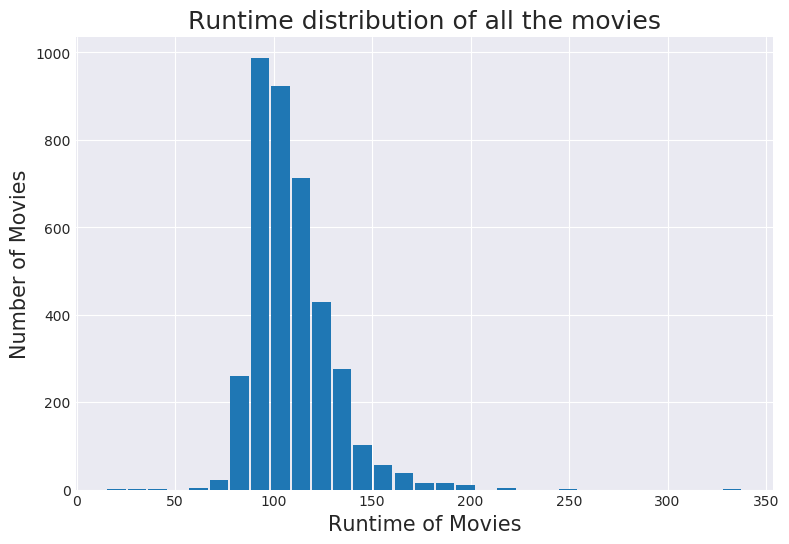

In [254]:
#plotting a histogram of runtime of movies

#gives styles to bg plot
sns.set_style('darkgrid')

#chaging the label size, this will change the size of all plots that we plot from now!
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)

#giving the figure size(width, height)
plt.figure(figsize=(9,6), dpi = 100)
#x-axis label name
plt.xlabel('Runtime of Movies', fontsize = 15)
#y-axis label name
plt.ylabel('Number of Movies', fontsize=15)
#title of the graph
plt.title('Runtime distribution of all the movies', fontsize=18)

#giving a histogram plot
plt.hist(df_tmdb['runtime'], rwidth = 0.9, bins =31)
#displays the plot
plt.show()

# Answer 2：

From the histogram，you can see the tallest bar here is time interval between `85-100 min`(approx) and around 1000 movies have the runtime between these time intervals. So we can also say from this graph that mode time of movies is around `85-110 min`, has the highest concentration of data points around this time interval. The distribution of this graph is positively skewed or right-skewed。

### Research Question 3：Which genre were more successful?

In [255]:
#assinging new dataframe which holds values only of movies having profit $50M or more
profit_movie_data = df_tmdb[df_tmdb['profit'] >= 50000000]

#reindexing new dataframe
profit_movie_data.index = range(len(profit_movie_data))
#will initialize dataframe from 1 instead of 0
profit_movie_data.index = profit_movie_data.index + 1

#showing the dataset
profit_movie_data.head(2)

,id,popularity,profit,budget,revenue,original_title,cast,director,tagline,runtime,genres,release_date,release_year,budget_adj
1,135397,32.985763,1363528810,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,The park is open.,124,Action|Adventure|Science Fiction|Thriller,2015-06-09,2015,1.379999e+08
2,76341,28.419936,228436354,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,What a Lovely Day.,120,Action|Adventure|Science Fiction|Thriller,2015-05-13,2015,1.379999e+08


In [256]:
#giving a new average function since we have a different dataset
def prof_avg_fuc(column_name):
    return profit_movie_data[column_name].mean()

In [257]:
#function which will take any column as argument from which data is need to be extracted and keep track of count
def extract_data(column_name):
    #will take a column, and separate the string by '|'
    all_data = profit_movie_data[column_name].str.cat(sep = '|')
    
    #giving pandas series and storing the values separately
    all_data = pd.Series(all_data.split('|'))
    
    #this will us value in descending order
    count = all_data.value_counts(ascending = False)
    
    return count

In [258]:
#this will variable will store the return value from a function
genre_count = extract_data('genres')
#shwoing top 5 values
genre_count.head()

Comedy       492
Drama        481
Action       464
Thriller     405
Adventure    379
dtype: int64

# Which cast is the most?

In [262]:
#this will variable will store the return value from a function
cast_count = extract_data('cast')
#shwoing top 5 values
cast_count.head()

Tom Cruise            27
Brad Pitt             25
Tom Hanks             22
Sylvester Stallone    21
Cameron Diaz          20
dtype: int64

In [259]:
#this will variable will store the return value from a function
director_count = extract_data('director')
#shwoing top 5 values
director_count.head()

Steven Spielberg    23
Robert Zemeckis     13
Clint Eastwood      12
Tim Burton          11
Ridley Scott        10
dtype: int64

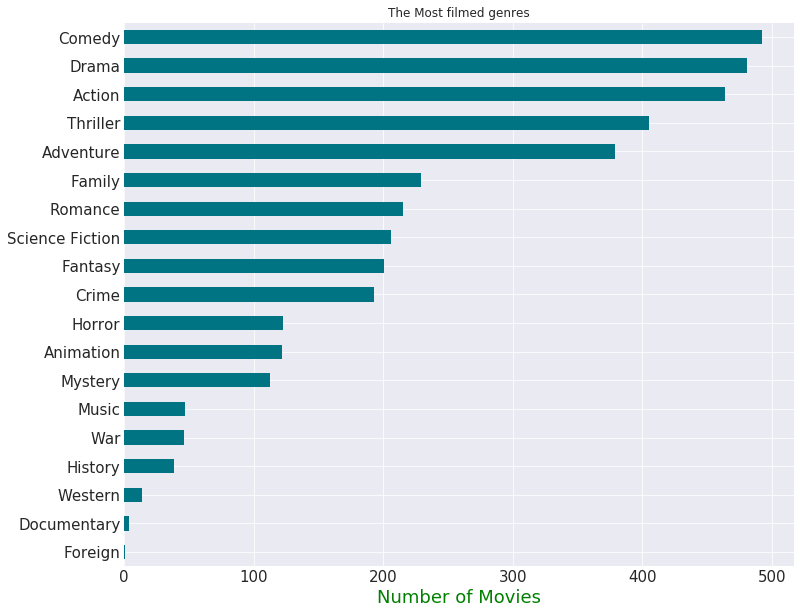

In [260]:
#we want plot to plot points in descending order top to bottom
#since our count is in descending order and graph plot points from bottom to top, our graph will be in ascending order form top to bottom
#hence lets give the series in ascending order
genre_count.sort_values(ascending = True, inplace = True)

#initializing plot
ax = genre_count.plot.barh(color = '#007482', fontsize = 15)

#giving a title
ax.set(title = 'The Most filmed genres')

#x-label
ax.set_xlabel('Number of Movies', color = 'g', fontsize = '18')

#giving the figure size(width, height)
ax.figure.set_size_inches(12, 10)

#shwoing the plot
plt.show()

# Answer 3：

From the graph above，` Comedy, Drama and Action genres` are the most as visualized but Comedy takes the prize, about `492 movies` have genres comedy which make $50M+ in profit. And  `Adventure` and `Thriller` are also profited. This appoved that thse five typ额of genres would have a significant interest and attraction to the population.

`Western, war, history, music, documentary` and the most least `foreign` genres have less probability to make this much in profit as in comparison to other genre.


<a id='conclusions'></a>
## Conclusions

**Q. If i wanted to show one of the best and most profitable movie, which genre would I choose，which director would I choose，how long the movies will it takes？</li>

<li>**Choose these genre** -Comedy, Drama， Action, Adventure, Thriller</li>
<li>**Choose any director from this** - Steven Spielberg, Robert Zemeckis, Clint Eastwood ，Tim Burton and Ridley Scott</li>
<li>**Choose cast from this** - Tom Cruise,Brad Pitt,Tom Hanks ,Sylvester Stallone and Cameron Diaz  </li>


By doing all this, my probability of making a profitable movie would be higher and obviously i will take care of other influential factors too. ; And also the runtime of the movie will be around 100-110 min. 


**Limitations** -  I want to make it clear, it's not 100 percent guaranteed solution that this formula is gonna work, meaning we are going to earn more than \$50M! But it shows us that we have high probability of making high profits if we had similar characteristics as such. All these directors,cast and genres have a common trend of attraction. If we release a movie with these characteristics, it gives people high expectations from this movie. Thus attracting more people towards the movie but it ultimately comes down to story mainly and also other important influential factors. People having higher expectations gives us less probability of meeting their expectations. Even if the movie was worth, people's high expectations would lead in biased results ultimately effecting the profits. We also see this in real life specially in sequels of movies. This was just one example of an influantial factor that would lead to different results, there are many that have to be taken care of!

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [261]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0